In [1]:
import json
import pandas as pd
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Utils

In [2]:
def get_ids(df):
    conversations = df.values.tolist()
    conversation_ids = []
    for conv in conversations:
        cur_conv = json.loads(conv)
        conversation_ids.append(list(cur_conv.keys())[0])
    return conversation_ids

In [3]:
def get_action_lst(conv):

    cur_conv = json.loads(conv)
    return list(cur_conv.keys())[0]

In [4]:
def non_readable_or_not_sure(df):
    df['not_English'] = (df['na'] == True)
    df['not_sure_toxicity'] = (df['toxic'] == -1)
    non_english = pd.DataFrame({'not_readable': df.groupby('_unit_id')['not_English'].mean() >=0.5}).reset_index()
    non_english = non_english[non_english['not_readable'] == True]['_unit_id'].values.tolist()
    not_sure_toxicity = pd.DataFrame({'not_sure_toxicity': df.groupby('_unit_id')['not_sure_toxicity'].mean() >= 0.5}).reset_index()
    not_sure_toxicity = not_sure_toxicity[not_sure_toxicity['not_sure_toxicity'] == True]['_unit_id'].values.tolist()
    return non_english + not_sure_toxicity

In [5]:
def attacker_in_conv(conv):
    actions = conv['action_feature']
    end_time = max([a['timestamp_in_sec'] for a in actions])
    attacker = None
    for a in actions:
        if a['timestamp_in_sec'] == end_time:
            attacker = a['user_text']
    for a in actions:
        if a['timestamp_in_sec'] < end_time and a['user_text'] == attacker:
            return True
    return False

In [10]:
constraint = "delta2_no_users"
job_suffix = 'constraintB_v018'

In [7]:
goods = {}
bads = []
all_data = {}
included = {}
inputs = []
with open('/scratch/wiki_dumps/expr_with_matching/%s/data/all.json'%constraint) as f:
    for line in f:
        conv_id, clss, conversation = json.loads(line)
        if conv_id in all_data:
            continue
        all_data[conv_id] = [conv_id, clss, conversation]
        inputs.append([conv_id, clss, conversation])
    for line in inputs:
        conv_id, clss, conversation = line
        if clss == 0:# and (attacker_in_conv(all_data[conversation['action_feature'][0]['good_conversation_id']][2])):
            bads.append([conv_id, clss, conversation])
            goods[conv_id] = all_data[conversation['action_feature'][0]['good_conversation_id']]
cleaned_data = bads + list(goods.values())
print(len(cleaned_data))

33374


# JOB 1

In [11]:
with open('/scratch/wiki_dumps/annotated/job1_%s.csv'%job_suffix) as f:
     df = pd.read_csv(f, encoding = 'utf-8', index_col=None, quoting=csv.QUOTE_ALL)

toxicity = df[df['toxic'] >= 0]
toxic_before = pd.DataFrame({'toxic_before': toxicity.groupby('_unit_id')['toxic'].mean() >= 0.5}).\
            reset_index()
toxic_before = toxic_before[toxic_before['toxic_before'] == True]['_unit_id'].values.tolist()
_excluded = list(set(non_readable_or_not_sure(df) + toxic_before))
annotated = set(get_ids(df['conversations']))
excluded_1 = set(get_ids(df[df['_unit_id'].isin(_excluded)]['conversations']))

In [12]:
toxicity_score = pd.DataFrame({'toxicity_score': toxicity.groupby('_unit_id')['toxic'].mean()}).\
            reset_index()
disagreement = df[df['disagreement'] >= 0]
disagreement_score = pd.DataFrame({'disagree_score': disagreement.groupby('_unit_id')['disagreement'].mean()}).\
            reset_index()
lead_to_toxic= df[~np.isnan(df['lead_to_toxic'])]
lead_to_toxic_score = pd.DataFrame({'lead_to_toxic_score': lead_to_toxic.groupby('_unit_id')['lead_to_toxic'].mean()}).reset_index()

In [13]:
no_annotators = pd.DataFrame({'no_annotators': df.groupby('_unit_id').size()}).\
            reset_index()

In [14]:
unit_ids = df[['_unit_id','conversations']].values.tolist()

id_conv_mapping = {}
for unit_id in unit_ids:
    curid, conv = unit_id
    id_conv_mapping[curid] = get_action_lst(conv)
unit_ids = id_conv_mapping

data = []
appeared = {}
for line in cleaned_data:
    conv_id, clss, conversation = line
    idlist = [k['id'] for k in conversation['action_feature']]
    if clss:
        matched_id = conversation['action_feature'][0]['bad_conversation_id']
    else:
        matched_id = conversation['action_feature'][0]['good_conversation_id']
    for curid, conv in id_conv_mapping.items():
        if conv in idlist and not(conv_id in appeared):
            data.append({'_unit_id': curid, 'conv_id': conv_id, 'matched_id': matched_id, 'class' : clss})
            appeared[conv_id] = True

In [15]:
conv_df = pd.DataFrame(data).set_index('_unit_id')
conv_df = conv_df.join(toxicity_score.set_index('_unit_id'))
conv_df = conv_df.join(disagreement_score.set_index('_unit_id'))
conv_df = conv_df.join(lead_to_toxic_score.set_index('_unit_id'))
conv_df = conv_df.join(no_annotators.set_index('_unit_id'))

In [24]:
# Each Conversation is annotated by 5~22 workers JOB1

# JOB 2

In [16]:
with open('/scratch/wiki_dumps/annotated/job2_%s.csv'%(job_suffix)) as f:
     df = pd.read_csv(f, encoding = 'utf-8', index_col=None, quoting=csv.QUOTE_ALL)

_excluded = list(set(non_readable_or_not_sure(df)))
excluded_2 = set(get_ids(df[df['_unit_id'].isin(_excluded)]['conversations']))
excluded = (excluded_1 | excluded_2)

In [17]:
df['conv_id'] = df.apply(lambda x: list(json.loads(x['conversations']).keys())[0], axis=1)

In [18]:
toxicity = df[df['toxic'] >= 0]
toxic = pd.DataFrame({'toxic': toxicity.groupby('_unit_id')['toxic'].mean() >= 0.5}).reset_index()
bad_convs = toxic[toxic['toxic'] == True]['_unit_id'].values.tolist()
bad_conversations = set(get_ids(df[df['_unit_id'].isin(bad_convs)]['conversations']))

In [19]:
df['has_disagreement'] = ~(df['disagreement'] == None)
disagreement = pd.DataFrame({'disagreement': df.groupby('_unit_id')['has_disagreement'].mean() >= 0.5}).reset_index()
disagree_convs = disagreement[disagreement['disagreement'] == True]['_unit_id'].values.tolist()
disagree_conversations = set(get_ids(df[df['_unit_id'].isin(disagree_convs)]['conversations']))

In [20]:
bad_and_disagree = (bad_conversations & disagree_conversations - excluded)
good_and_disagree = (disagree_conversations - bad_conversations - excluded)

In [21]:
len(cleaned_data)

33374

In [22]:
data = []
bad_disagree = []
good_disagree = []
xs = []
total_bad = 0
total_good = 0
for line in cleaned_data:
    conv_id, clss, conversation = line
    idlist = [k['id'] for k in conversation['action_feature']]
    is_annotated = not(annotated.isdisjoint(idlist))
    is_excluded = not(excluded.isdisjoint(idlist))
    is_bd = not(bad_and_disagree.isdisjoint(idlist))
    is_gd = not(good_and_disagree.isdisjoint(idlist))
    annotated_class = bad_conversations.isdisjoint(idlist)
    same_class = (int(annotated_class) == clss)
    if 'good_conversation_id' in conversation['action_feature'][0]:
        matched_id = conversation['action_feature'][0]['good_conversation_id']
    else:
        matched_id = conversation['action_feature'][0]['bad_conversation_id']
    dt = {'conversation_id': conv_id, 'annotated': is_annotated, 'excluded': is_excluded, \
        'annotated_class': annotated_class, 'class': clss, 'matched_id': matched_id, 'same_class': same_class}
    if is_bd and not(is_excluded) and is_annotated:
        bad_disagree.append(dt)
    if is_gd and not(is_excluded):
        good_disagree.append(dt)
    if annotated_class:
        total_good += 1
    else:total_bad += 1
    data.append(dt)

In [23]:
bad_but_disagree = pd.DataFrame(bad_disagree)
good_but_disagree = pd.DataFrame(good_disagree)
print('Number of bad conversations with disagreement :', len(bad_but_disagree))
print('Total Number of bad conversations:', total_bad)
print('Number of good conversations with disagreement :', len(good_but_disagree))
print('Total Number of bad conversations:', total_good)
print('Good conversations with disagreement / good conversations:', len(good_but_disagree) / total_good)
print('Bad conversations with disagreement / bad conversations:', len(bad_but_disagree) / total_bad)
print('Bad conversations with disagreement / all conversations with disagreement', len(bad_but_disagree) / (len(good_but_disagree) + len(bad_but_disagree)))
print('Number of bad conversations / all conversations:', total_bad/(total_bad+total_good))

Number of bad conversations with disagreement : 9002
Total Number of bad conversations: 9057
Number of good conversations with disagreement : 17892
Total Number of bad conversations: 24317
Good conversations with disagreement / good conversations: 0.735781552000658
Bad conversations with disagreement / bad conversations: 0.9939273490118141
Bad conversations with disagreement / all conversations with disagreement 0.33472149921915667
Number of bad conversations / all conversations: 0.27137891772038114


In [24]:
annotation_aggregated = pd.DataFrame(data)
print('Number of Conversations Annotated:', len(annotation_aggregated[annotation_aggregated['annotated'] == True]))
print('Number of Conversations Excluded:', len(annotation_aggregated[annotation_aggregated['excluded'] == True]))
annotation_aggregated = annotation_aggregated[(annotation_aggregated['annotated'] == True)\
                                              & (annotation_aggregated['excluded'] == False)\
                                              & (annotation_aggregated['same_class'] == True)]
left_ids = annotation_aggregated['conversation_id'].values.tolist()
annotation_aggregated = annotation_aggregated[annotation_aggregated['matched_id'].isin(left_ids)]
print('Number of Conversations left:', len(annotation_aggregated))

Number of Conversations Annotated: 27294
Number of Conversations Excluded: 400
Number of Conversations left: 16772


In [25]:
verified_pairs = annotation_aggregated['conversation_id'].values.tolist()
conv_df = conv_df[conv_df['conv_id'].isin(verified_pairs)]

In [26]:
conv_df = conv_df.set_index('conv_id')

In [27]:
for var in ['toxicity', 'disagree', 'lead_to_toxic']:
    conv_df['%s_equals'%(var)] = conv_df.apply(lambda x: 1 if conv_df.loc[x['matched_id']]['%s_score'%(var)] == x['%s_score'%(var)] else 0, axis=1)
    conv_df['%s_annotation'%(var)] = conv_df.apply(lambda x: 1 if conv_df.loc[x['matched_id']]['%s_score'%(var)] > x['%s_score'%(var)] else 0, axis=1)

In [28]:
for var in ['toxicity', 'disagree', 'lead_to_toxic']:
    print(var + ' accuracy :', len(conv_df[conv_df['%s_annotation'%(var)] == conv_df['class']]) / len(conv_df))
    tmp_df = conv_df[conv_df['%s_equals'%var] == 0]
    print(var + ' number of equals:', len(conv_df) - len(tmp_df))
    print(var + ' accuracy without equals:', len(tmp_df[tmp_df['%s_annotation'%(var)] == tmp_df['class']]) \
        / len(tmp_df))
    print('\n')

toxicity accuracy : 0.5111495349391844
toxicity number of equals: 9750
toxicity accuracy without equals: 0.5266305895756195


disagree accuracy : 0.43846887669926066
disagree number of equals: 1044
disagree accuracy without equals: 0.43438453713123093


lead_to_toxic accuracy : 0.4974362031958025
lead_to_toxic number of equals: 1042
lead_to_toxic accuracy without equals: 0.4972663699936427




/home/yiqing/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


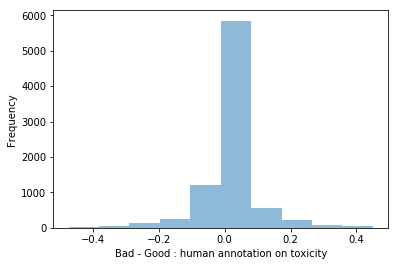

0.0260004706923 0.0308239342418 WilcoxonResult(statistic=2823803.5, pvalue=1.3344412408900053e-05)
Bad - Good < 0 1662
Bad - Good > 0 1849
Bad - Good == 0 4875


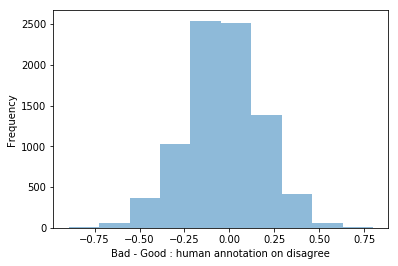

0.220091616454 0.186359551232 WilcoxonResult(statistic=12613601.5, pvalue=1.8384250123401934e-45)
Bad - Good < 0 4448
Bad - Good > 0 3416
Bad - Good == 0 522


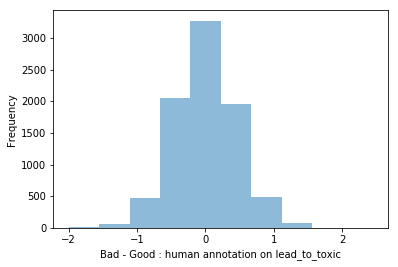

-1.48789161861 -1.49012733199 WilcoxonResult(statistic=15306526.0, pvalue=0.42681049786510439)
Bad - Good < 0 3954
Bad - Good > 0 3911
Bad - Good == 0 521


In [29]:
for var in ['toxicity', 'disagree', 'lead_to_toxic']:
    all_good = conv_df[conv_df['class'] == 1]
    all_good['%s_gap'%(var)] = all_good.apply(lambda x: conv_df.loc[x['matched_id']]['%s_score'%(var)] - x['%s_score'%(var)], axis=1)
    plt.figure()
    all_good['%s_gap'%(var)].plot.hist(alpha=0.5)
    plt.xlabel('Bad - Good : human annotation on %s'%(var))
    plt.show()
    good = conv_df[conv_df['class'] == 1]['%s_score'%(var)].values.tolist()
    bad = conv_df[conv_df['class'] == 0]['%s_score'%(var)].values.tolist()
    print(np.mean(good), np.mean(bad), scipy.stats.wilcoxon(good, bad))
    print('Bad - Good < 0', len(all_good[all_good['%s_gap'%(var)] < 0]))
    print('Bad - Good > 0', len(all_good[all_good['%s_gap'%(var)] > 0]))
    print('Bad - Good == 0', len(all_good[all_good['%s_gap'%(var)] == 0]))

In [30]:
test = {}
with open('/scratch/wiki_dumps/expr_with_matching/%s/data/never_seen.json'%(constraint)) as f:
    for line in f:
        conv_id, clss, conversation = json.loads(line)
        test[conv_id] = True

In [31]:
left = []
with open('/scratch/wiki_dumps/expr_with_matching/%s/data/test_verified.json'%(constraint), 'w') as w:
    for conv in cleaned_data:
        conv_id, clss, conversation = conv
        if not(conv_id in verified_pairs):
            continue
        if not(conv_id in test):
            left.append(conv)
        else:
            w.write(json.dumps(conv) + '\n')
print(len(left))
with open('/scratch/wiki_dumps/expr_with_matching/%s/data/train_verified.json'%(constraint), 'w') as w:
    for conv in left:
        w.write(json.dumps(conv) + '\n')

14808


# Annotator Agreement

In [9]:
TOXIC_COLUMNS = ['no_toxic', 'toxic']

no_toxic = pd.DataFrame({'no_toxic': df[df['toxic'] == 0].groupby('_unit_id').size()}).reset_index().set_index('_unit_id')
toxic = pd.DataFrame({'toxic': df[df['toxic'] == 1].groupby('_unit_id').size()}).reset_index().set_index('_unit_id')
total = toxic.join(no_toxic, how='outer')
total = total.fillna(int(0)).reset_index()
total['sum'] = total['toxic'] + total['no_toxic']
#total = total[total['sum'] ==20]

len(total[total['sum'] >=20]) / len(total)

total = total[total['sum'] == 5]

total['toxic'] = total.apply(lambda x: int(x['toxic']), axis=1)

total['sum'] = total['toxic'] + total['no_toxic']

total[['sum']].plot.hist

n,bins,batches = plt.hist(total['no_toxic'])

len(total[total['no_toxic'] > 20]) / len(total)

plt.show()

total = total[~(total['_unit_id'].isin(_excluded))]

print(len(total), Krippendorf_alpha(total, TOXIC_COLUMNS))

In [164]:
TOXIC_COLUMNS = ['no_toxic', 'toxic']

no_toxic = pd.DataFrame({'no_toxic': df[df['toxic'] == 0].groupby('_unit_id').size()}).reset_index().set_index('_unit_id')
toxic = pd.DataFrame({'toxic': df[df['toxic'] == 1].groupby('_unit_id').size()}).reset_index().set_index('_unit_id')
total = toxic.join(no_toxic, how='outer')
total = total.fillna(0).reset_index()
total['sum'] = total['toxic'] + total['no_toxic']
total = total[total['sum'] ==20]

2643 0.282819056548
